To perform registration with `DiffDRR`, we do the following:

1. Obtain a target X-ray (this is the image whose pose parameters we wish to recovery)
2. Initialize a moving DRR module from a random camera pose
3. Measure the loss between the target X-ray and the moving DRR (we use normalized negative cross-correlation)
4. Backpropogate this loss to the pose parameters of the moving DRR and render from the new pose
5. Repeat Steps 3-4 until the loss has converged

## 1. Generate a target X-ray

In [7]:
#| code-fold: true
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm

from diffdrr.data import load_example_mr
from diffdrr.data import load_example_mammo
from diffdrr.drr import DRR
from diffdrr.metrics import NormalizedCrossCorrelation2d
from diffdrr.pose import convert
from diffdrr.registration import Registration
from diffdrr.visualization import plot_drr

# Make the ground truth X-ray
SDD = 1020.0
HEIGHT = 200
DELX = 2.0

#this one should be mammogram
mammo_subject = load_example_mammo()
mr_subject = load_example_mr()

mammo_true_params = {
    "sdr": SDD,
    "alpha": 0.0,
    "beta": -90.0,
    "gamma": 0.0,
    "bx": 10.0,
    "by": 750.0,
    "bz": 5.0,
}

mri_true_params = {
    "sdr": SDD,
    "alpha": 0.0,
    "beta": 90.0,
    "gamma": -105.0,
    "bx": 0.0,
    "by": 850.0,
    "bz": 0.0,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(mammo_subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor(
    [[mammo_true_params["alpha"], mammo_true_params["beta"], mammo_true_params["gamma"]]]
)
translations = torch.tensor([[mammo_true_params["bx"], mammo_true_params["by"], mammo_true_params["bz"]]])
gt_pose = convert(
    rotations, translations, parameterization="euler_angles", convention="ZXY"
).to(device)
ground_truth = drr(gt_pose)

#plot_drr(ground_truth)
#plt.show()

ImageSeriesReader (0x15a604290): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000393273



## 2. Initialize a moving DRR from a random pose

The random pose is parameterized as a perturbation of the true pose.
Angular perturbations are uniformly sampled from [-π/4, π/4] and translational perturbations are uniformly sampled from [-30, 30].

In [8]:
#| code-fold: true
# Make a random DRR
np.random.seed(1)


def pose_from_carm(sid, tx, ty, alpha, beta, gamma):
    rot = torch.tensor([[alpha, beta, gamma]])
    xyz = torch.tensor([[tx, sid, ty]])
    return convert(rot, xyz, parameterization="euler_angles", convention="ZXY")


def get_initial_parameters(true_params):
    alpha = 0.0#true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = -90.0#true_params["beta"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    gamma = -90.0#true_params["gamma"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    bx = 10.0#true_params["bx"] + np.random.uniform(-30.0, 30.0)
    by = 600.0#true_params["by"] + np.random.uniform(-30.0, 30.0)
    bz = 5.0#true_params["bz"] + np.random.uniform(-30.0, 30.0)
    pose = pose_from_carm(by, bx, bz, alpha, beta, gamma).to(device)
    rotations, translations = pose.convert("euler_angles", "ZXY")
    return rotations, translations, pose

#this one should be mri proj
rotations, translations, pose = get_initial_parameters(mammo_true_params)
drr = DRR(mr_subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(pose)
#plot_drr(est)
#plt.show()

rotations, translations

(tensor([[-3.1416, -1.1062,  1.1062]]),
 tensor([[ 10.0000, 600.0000,   5.0000]]))

## 3. Measure the loss between the target X-ray and moving DRR

We start by measuring the initial loss between the two images.

In [4]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth, est).item()

0.31970030069351196

If the negative normalized cross-correlation is greater than 0.999, we say the target and moving DRR have converged.

## 4. Backpropogate the loss to the moving DRR parameters

We also use this example to show how different optimizers affect the outcome of registration.
The parameters we tweak are

- `lr_rotations`: learning rate for rotation parameters
- `lr_translations`: learning rate for translation parameters
- `momentum`: momentum for stochastic gradient descent
- `dampening`: dampening for stochastic gradient descent

A basic implementation of an optimization loop is provided below:

In [7]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5e-2,
    lr_translations=1e2,
    momentum=0,
    dampening=0,
    n_itrs=500,
    optimizer="sgd",  # 'sgd' or `adam`
):
    # Initialize an optimizer with different learning rates
    # for rotations and translations since they have different scales
    if optimizer == "sgd":
        optim = torch.optim.SGD(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
        optimizer = optimizer.upper()
    elif optimizer == "adam":
        optim = torch.optim.Adam(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            maximize=True,
        )
        optimizer = optimizer.title()
    else:
        raise ValueError(f"Unrecognized optimizer {optimizer}")

    params = []
    losses = [criterion(ground_truth, reg()).item()]
    for itr in (pbar := tqdm(range(n_itrs), ncols=100)):
        # Save the current set of parameters
        alpha, beta, gamma = reg.rotation.squeeze().tolist()
        bx, by, bz = reg.translation.squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optim.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        pbar.set_description(f"NCC = {loss.item():06f}")

        # Stop the optimization if the estimated and ground truth images are 99.9% correlated
        if loss > 0.999:
            if momentum != 0:
                optimizer += " + momentum"
            if dampening != 0:
                optimizer += " + dampening"
            tqdm.write(f"{optimizer} converged in {itr + 1} iterations")
            break

    # Save the final estimated pose
    alpha, beta, gamma = reg.rotation.squeeze().tolist()
    bx, by, bz = reg.translation.squeeze().tolist()
    params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

The [PyTorch implementation of L-BFGS](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html) has a different API to many other optimizers in the library. Notably, it requires a `closure` function to evaluate the model multiple times before taking a step. Also, it does not accept per-parameter learning rates nor a `maximize` flag. Below is an implementation of L-BFGS for `DiffDRR`.

In [8]:
#| code-fold: true
def optimize_lbfgs(
    reg: Registration,
    ground_truth,
    lr,
    line_search_fn=None,
    n_itrs=500,
):
    # Initialize the optimizer and define the closure function
    optim = torch.optim.LBFGS(reg.parameters(), lr, line_search_fn=line_search_fn)

    def closure():
        if torch.is_grad_enabled():
            optim.zero_grad()
        estimate = reg()
        loss = -criterion(ground_truth, estimate)
        if loss.requires_grad:
            loss.backward()
        return loss

    params = []
    losses = [closure().abs().item()]
    for itr in (pbar := tqdm(range(n_itrs), ncols=100)):
        # Save the current set of parameters
        alpha, beta, gamma = reg.rotation.squeeze().tolist()
        bx, by, bz = reg.translation.squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optim.step(closure)
        with torch.no_grad():
            loss = closure().abs().item()
            losses.append(loss)
            pbar.set_description(f"NCC = {loss:06f}")

        # Stop the optimization if the estimated and ground truth images are 99.9% correlated
        if loss > 0.999:
            if line_search_fn is not None:
                method = f"L-BFGS + strong Wolfe conditions"
            else:
                method = "L-BFGS"
            tqdm.write(f"{method} converged in {itr + 1} iterations")
            break

    # Save the final estimated pose
    alpha, beta, gamma = reg.rotation.squeeze().tolist()
    bx, by, bz = reg.translation.squeeze().tolist()
    params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

## 5. Run the optimization algorithm

Below, we compare the following gradient-based iterative optimization methods:

- SGD
- SGD + momentum
- SGD + momentum + dampening
- Adam
- L-BFGS
- L-BFGS + line search

In [9]:
# Keyword arguments for diffdrr.drr.DRR
kwargs = {
    "subject": mr_subject,
    "sdd": SDD,
    "height": HEIGHT,
    "delx": DELX,
    "stop_gradients_through_grid_sample": True,  # Enables faster optimization
}

In [10]:
#| code-fold: true
# Base SGD
drr = DRR(**kwargs).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_base = optimize(reg, ground_truth)
del drr

# SGD + momentum
drr = DRR(**kwargs).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum = optimize(reg, ground_truth, momentum=5e-1)
del drr

# SGD + momentum + dampening
drr = DRR(**kwargs).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum_dampen = optimize(reg, ground_truth, momentum=5e-1, dampening=1e-4)
del drr

# Adam
drr = DRR(**kwargs).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_adam = optimize(reg, ground_truth, 1e-1, 5e0, optimizer="adam")
del drr

# L-BFGS
drr = DRR(**kwargs).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_lbfgs = optimize_lbfgs(reg, ground_truth, lr=3e-1)
del drr

# L-BFGS + line search
drr = DRR(**kwargs).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_lbfgs_wolfe = optimize_lbfgs(
    reg, ground_truth, lr=1e0, line_search_fn="strong_wolfe"
)
del drr

  0%|                                                                       | 0/500 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss = float(closure())
NCC = 0.739002: 100%|█████████████████████████████████████████████| 500/500 [40:55<00:00,  4.91s/it]


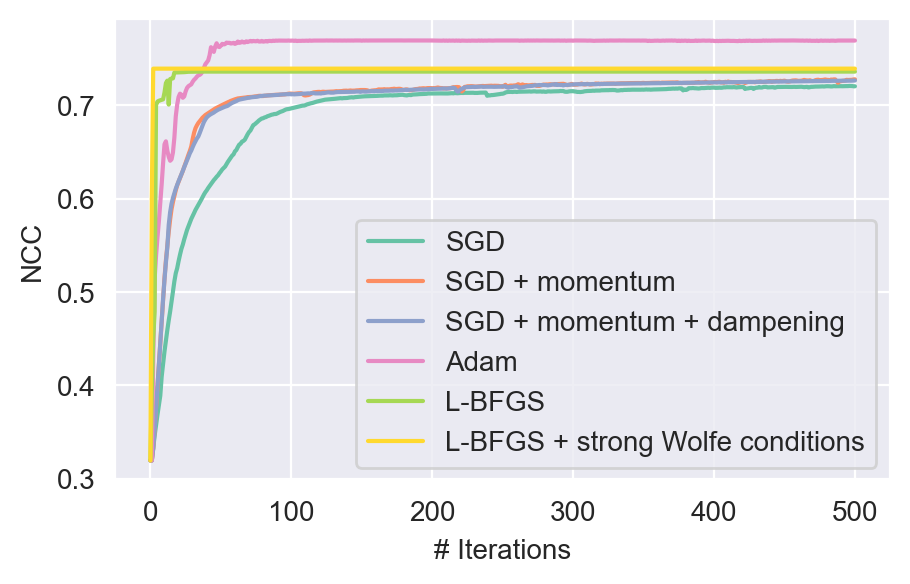

In [11]:
#| code-fold: true
parameters = {
    "SGD": (params_base, "#66c2a5"),
    "SGD + momentum": (params_momentum, "#fc8d62"),
    "SGD + momentum + dampening": (params_momentum_dampen, "#8da0cb"),
    "Adam": (params_adam, "#e78ac3"),
    "L-BFGS": (params_lbfgs, "#a6d854"),
    "L-BFGS + strong Wolfe conditions": (params_lbfgs_wolfe, "#ffd92f"),
}

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(5, 3), dpi=200)
    for name, (df, color) in parameters.items():
        plt.plot(df["loss"], label=name, color=color)
    plt.xlabel("# Iterations")
    plt.ylabel("NCC")
    plt.legend()
    plt.show()

Visualizing the loss curves allows us to interpret interesting dynamics during optimization:

- SGD and its variants all arrive at a local maximum around NCC = 0.95, and take differing numbers of iterations to escape the local maximum
- While Adam arrives at the answer much faster, its loss curve is not monotonically increasing, which we will visualize in the next section
- L-BFGS *without* line search is slow and each iteration takes much longer than first-order methods
- L-BFGS *with* line seach is highly efficient in terms of number of iterations required, and it runs in roughly the same time as the best first-order gradient-based method

## Visualize the parameter updates

Note that differences that between different optimization algorithms can be seen in the motion in the DRRs!

In [12]:
#| code-fold: true
from base64 import b64encode

from IPython.display import HTML, display

from diffdrr.visualization import animate

MAX_LENGTH = max(
    map(
        len,
        [
            params_base,
            params_momentum,
            params_momentum_dampen,
            params_adam,
            params_lbfgs,
            params_lbfgs_wolfe,
        ],
    )
)
drr = DRR(mr_subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)


def animate_in_browser(df, skip=1, max_length=MAX_LENGTH, duration=30):
    if max_length is not None:
        n = max_length - len(df)
        df = pd.concat([df, df.iloc[[-1] * n]]).iloc[::skip]
    else:
        pass

    out = animate(
        "<bytes>",
        df,
        drr,
        ground_truth=ground_truth,
        verbose=True,
        device=device,
        extension=".webp",
        duration=duration,
        parameterization="euler_angles",
        convention="ZXY",
    )
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))

In [4]:
#animate_in_browser(params_base)

In [3]:
#animate_in_browser(params_momentum)

In [2]:
#animate_in_browser(params_momentum_dampen)

In [1]:
#animate_in_browser(params_adam)

In [ ]:
animate_in_browser(params_lbfgs)

Precomputing DRRs: 100%|█████████████████| 262/262 [00:43<00:00,  6.04it/s]


In [ ]:
animate_in_browser(params_lbfgs_wolfe)

Precomputing DRRs: 100%|█████████████████| 262/262 [00:43<00:00,  6.06it/s]


L-BFGS with converges in so few iterations that a GIF with ~30 FPS is imperceptible. Here's the same GIFs, but at 4 FPS.

In [ ]:
animate_in_browser(params_lbfgs, max_length=len(params_lbfgs), duration=250)

Precomputing DRRs: 100%|███████████████████| 38/38 [00:06<00:00,  6.07it/s]


In [ ]:
animate_in_browser(params_lbfgs_wolfe, max_length=len(params_lbfgs), duration=250)

Precomputing DRRs: 100%|███████████████████| 38/38 [00:07<00:00,  5.07it/s]


## Visualize the optimization trajectories

Finally, using PyVista, we can visualize the trajectory of the estimated camera poses over time for each of the optimization methods.

- SGD and its variants take more direct routes to the true camera pose (seagreen, orange, blue)
- Adam takes the most winding route but gets there faster than SGD (pink)
- Basic L-BFGS also takes a winding route, doubling back on itself at some points, and slowly reaches the solution (green)
- L-BFGS with a line search function reaches the solution very directly, while incurring a higher runtime per iteration (yellow)

In [17]:
#| code-fold: true
import pyvista

from diffdrr.visualization import drr_to_mesh, img_to_mesh

pyvista.start_xvfb()


def df_to_mesh(drr, df):
    pts = []
    for idx in tqdm(range(len(df))):
        rot = torch.tensor(df.iloc[idx][["alpha", "beta", "gamma"]].tolist())
        xyz = torch.tensor(df.iloc[idx][["bx", "by", "bz"]].tolist())
        pose = convert(
            rot.unsqueeze(0),
            xyz.unsqueeze(0),
            parameterization="euler_angles",
            convention="ZXY",
        ).cuda()
        with torch.no_grad():
            source, _ = drr.detector(pose, None)
        pts.append(source.squeeze().cpu().tolist())
    return *img_to_mesh(drr, pose), lines_from_points(np.array(pts))


def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pyvista.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly.tube(radius=3)


plotter = pyvista.Plotter()
ct = drr_to_mesh(drr.subject, "surface_nets", 150, verbose=False)
plotter.add_mesh(ct)

# SGD
camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_base)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="#66c2a5", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="#66c2a5")

# SGD + momentum
camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_momentum)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="#fc8d62", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="#fc8d62")

# SGD + momentum + dampening
camera, detector, texture, principal_ray, points = df_to_mesh(
    drr, params_momentum_dampen
)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="#8da0cb", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="#8da0cb")

# Adam
camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_adam)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="#e78ac3", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="#e78ac3")

# L-BFGS
camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_lbfgs)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="#a6d854", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="#a6d854")

# L-BFGS + line search
camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_lbfgs_wolfe)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="#ffd92f", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="#ffd92f")

# Ground truth
camera, detector, texture, principal_ray = img_to_mesh(drr, gt_pose)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="black", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.export_html("registration_runs.html")

/Users/rikki/PycharmProjects/MRI_DiffDRR/.venv/lib/python3.13/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


OSError: Please install Xvfb with:

Debian
$ sudo apt install libgl1-mesa-glx xvfb

CentOS / RHL
$ sudo yum install libgl1-mesa-glx xvfb



In [19]:
from IPython.display import IFrame

IFrame("registration_runs.html", height=500, width=749)